In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [147]:
data = pd.read_csv('data/weatherAUS.csv')

# Data Exploration

In [148]:
data.head() 

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

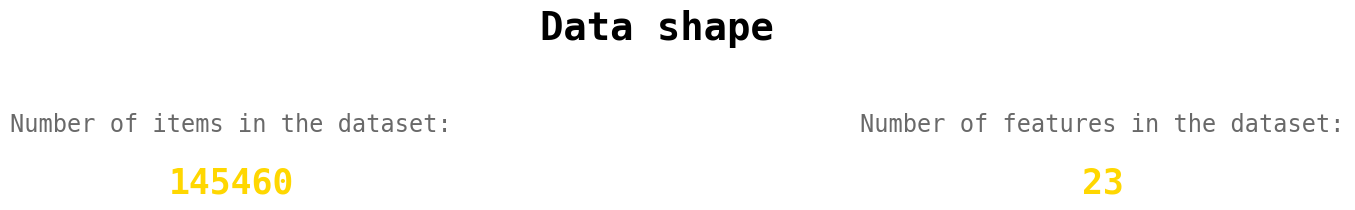

In [149]:
# inspiration code: https://www.kaggle.com/dwin183287/covid-19-world-vaccination
fig=plt.figure(figsize=(5,2),facecolor='white')

ax0=fig.add_subplot(1,1,1)
ax0.text(1.1,1,"Data shape",color='black',fontsize=28, fontweight='bold', fontfamily='monospace',ha='center')

ax0.text(0,0.001,data.shape[0],color='gold',fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(0,0.4,"Number of items in the dataset:",color='dimgrey',fontsize=17, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(2.25,0.001,data.shape[1],color='gold',fontsize=25, fontweight='bold', fontfamily='monospace',ha='center')
ax0.text(2.25,0.4,"Number of features in the dataset:",color='dimgrey',fontsize=17, fontweight='light', fontfamily='monospace',ha='center')

ax0.set_yticklabels('')
ax0.tick_params(axis='y',length=0)
ax0.tick_params(axis='x',length=0)
ax0.set_xticklabels('')

for direction in ['top','right','left','bottom']:
    ax0.spines[direction].set_visible(False)

In [150]:
data.info() #data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

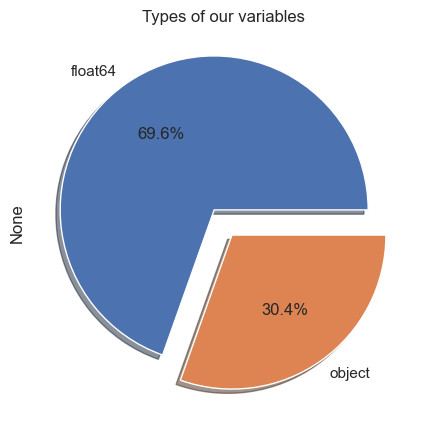

In [151]:
fig, ax = plt.subplots(figsize=(8, 5))
data.dtypes.value_counts().plot.pie(explode=[0.1, 0.1], autopct='%1.1f%%', shadow=True, ax=ax);
ax.set_title("Types of our variables", fontsize=12)
plt.show()

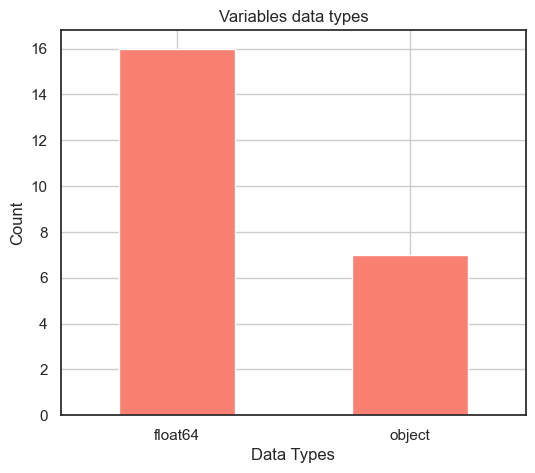

In [152]:
dtype_counts = data.dtypes.value_counts()

plt.figure(figsize=(6, 5))
dtype_counts.plot(kind='bar', color='salmon')
plt.title('Variables data types')
plt.xlabel('Data Types')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(True)  
plt.show()


**Let's take analyze target variable "RainTomorrow"**. 

The first thing we can notice is that the target variable contains some null values. To handle this, we'll impute the missing values using mode simply because we're in a binary calssificaion and using mean will generate a float variable.

In [153]:
mode_value = data['RainTomorrow'].mode()[0]
data['RainTomorrow'] = data['RainTomorrow'].fillna(mode_value)

In [154]:
if data['RainTomorrow'].isna().sum() == 0:
    print('NOO MORE MISSING VALUES IN THE TARGET COLUMN! :)')

NOO MORE MISSING VALUES IN THE TARGET COLUMN! :)


Now let's evaluate our classes

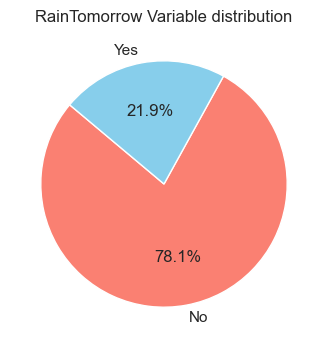

In [155]:
fig = plt.figure(figsize=(5, 4))
data['RainTomorrow'].value_counts(normalize=True).plot.pie(colors=['salmon', 'skyblue'], autopct='%1.1f%%', startangle=140)
plt.title('RainTomorrow Variable distribution')
plt.ylabel('')  
plt.show()

Out of the total number of RainTomorrow values, **'No' appears 77.58% times and 'Yes' appears 22.42% times**. This means that we have to deal with a **class imbalance** in our dataset.
For this we've decided to use **Synthetic Minority Oversampling Technique (SMOTE)** to generate synthetic data for the minority class

SMOTE works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors. It works in 4 simple steps:

- Choose a minority class as the input vector.
- Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function).
- Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor.
- Repeat the steps until the data is balanced.

NOTE:

Before applying SMOTE for oversampling, it's important to perform some preprocessing steps to prepare the data ( Handle Missing values - Encode categorical variables - Normalization or Standardization - Split data to train and test)

### FIRST: Let's handale missing values


In [156]:
# create a table with missing data 
missing_values=data.isnull().sum() 

missing_percentage = data.isnull().sum()/df.shape[0]*100

value = {
    'missing_values':missing_values,
    'missing_percent %':missing_percentage , 
     'data type' : data.dtypes
}
missing=pd.DataFrame(value)
missing_data_table = missing.sort_values(by='missing_values', ascending=False)

missing_data_table

missing_values  missing_percent % data type
Sunshine                69835          48.009762   float64
Evaporation             62790          43.166506   float64
Cloud3pm                59358          40.807095   float64
Cloud9am                55888          38.421559   float64
Pressure9am             15065          10.356799   float64
Pressure3pm             15028          10.331363   float64
WindDir9am              10566           7.263853    object
WindGustDir             10326           7.098859    object
WindGustSpeed           10263           7.055548   float64
Humidity3pm              4507           3.098446   float64
WindDir3pm               4228           2.906641    object
Temp3pm                  3609           2.481094   float64
Rainfall                 3261           2.241853   float64
RainToday                3261           2.241853    object
WindSpeed3pm             3062           2.105046   float64
Humidity9am              2654           1.824557   float64
WindSpeed9am             1767           1.214767   float64
Temp9am                  1767           1.214767   float64
MinTemp                  1485           1.020899   float64
MaxTemp                  1261           0.866905   float64
Date                        0           0.000000    object
Location                    0           0.000000    object
RainTomorrow                0           0.000000    object

 “Sunshine”, “Evaporation”, “Cloud3pm”, “Cloud9am” are very clearely the features with the highest missing values percentage. Let's Plot all the features with null values to decide which imputation method to use.

In [157]:
data.describe()

MinTemp        MaxTemp       Rainfall   Evaporation  \
count  143975.000000  144199.000000  142199.000000  82670.000000   
mean       12.194034      23.221348       2.360918      5.468232   
std         6.398495       7.119049       8.478060      4.193704   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.900000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  75625.000000  135197.000000  143693.000000  142398.000000   
mean       7.611178      40.035230      14.043426      18.662657   
std        3.785483      13.607062       8.915375       8.809800   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.800000      31.000000       7.000000      13.000000   
50%        8.400000      39.000000      13.000000      19.000000   
75%       10.600000      48.000000      19.000000      24.000000   
max       14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm   Pressure9am    Pressure3pm  \
count  142806.000000  140953.000000  130395.00000  130432.000000   
mean       68.880831      51.539116    1017.64994    1015.255889   
std        19.029164      20.795902       7.10653       7.037414   
min         0.000000       0.000000     980.50000     977.100000   
25%        57.000000      37.000000    1012.90000    1010.400000   
50%        70.000000      52.000000    1017.60000    1015.200000   
75%        83.000000      66.000000    1022.40000    1020.000000   
max       100.000000     100.000000    1041.00000    1039.600000   

           Cloud9am      Cloud3pm        Temp9am       Temp3pm  
count  89572.000000  86102.000000  143693.000000  141851.00000  
mean       4.447461      4.509930      16.990631      21.68339  
std        2.887159      2.720357       6.488753       6.93665  
min        0.000000      0.000000      -7.200000      -5.40000  
25%        1.000000      2.000000      12.300000      16.60000  
50%        5.000000      5.000000      16.700000      21.10000  
75%        7.000000      7.000000      21.600000      26.40000  
max        9.000000      9.000000      40.200000      46.70000

From the description table, we've noticed that some of the features may contain outliers. Let's make some visualizations to confirm whether our assumption is true.

(array([1, 2, 3, 4]),
 [Text(1, 0, 'MinTemp'),
  Text(2, 0, 'MaxTemp'),
  Text(3, 0, 'Temp9am'),
  Text(4, 0, 'Temp3pm')])

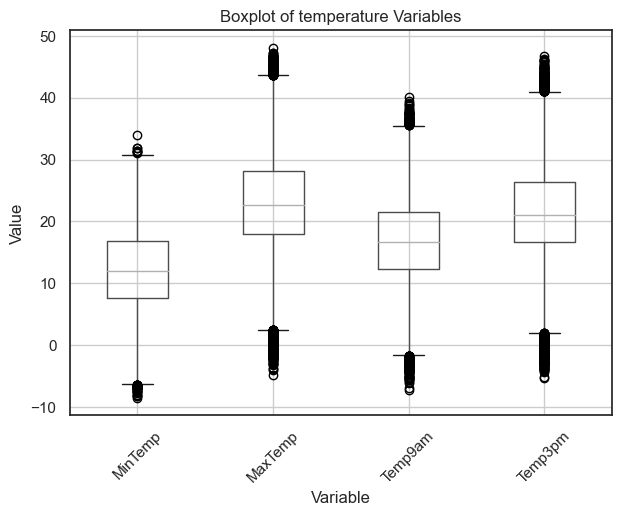

In [158]:
df = pd.DataFrame(data, columns=['MinTemp', 'MaxTemp','Temp9am', 'Temp3pm'])

# Plot boxplots for each column
plt.figure(figsize=(7,5))
df.boxplot(grid=True)
plt.title('Boxplot of temperature Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation=45)  


(array([1, 2, 3]),
 [Text(1, 0, 'WindGustSpeed'),
  Text(2, 0, 'WindSpeed9am'),
  Text(3, 0, 'WindSpeed3pm')])

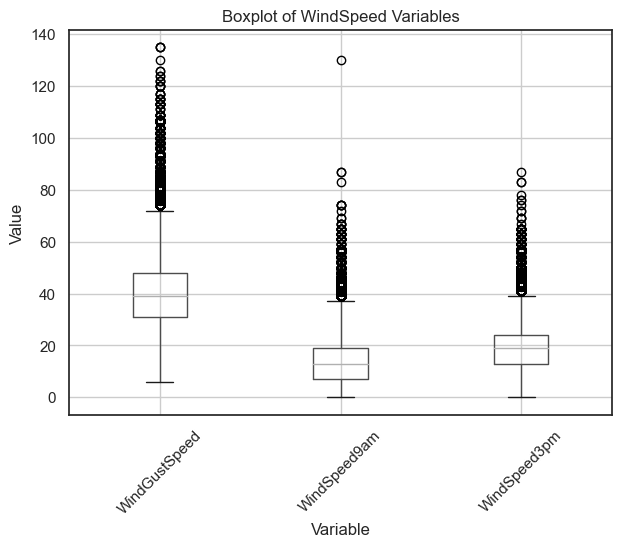

In [159]:

df = pd.DataFrame(data, columns=['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'])

# Plot boxplots for each column
plt.figure(figsize=(7,5))
df.boxplot(grid=True)
plt.title('Boxplot of WindSpeed Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation=45)  


(array([1, 2]), [Text(1, 0, 'Humidity9am'), Text(2, 0, 'Humidity3pm')])

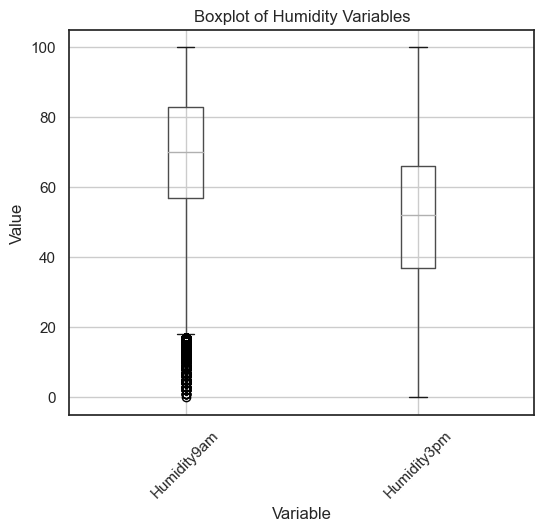

In [160]:

df = pd.DataFrame(data, columns=['Humidity9am', 'Humidity3pm'])

# Plot boxplots for each column
plt.figure(figsize=(6,5))
df.boxplot(grid=True)
plt.title('Boxplot of Humidity Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation=45)  


(array([1, 2]), [Text(1, 0, 'Pressure9am'), Text(2, 0, 'Pressure3pm')])

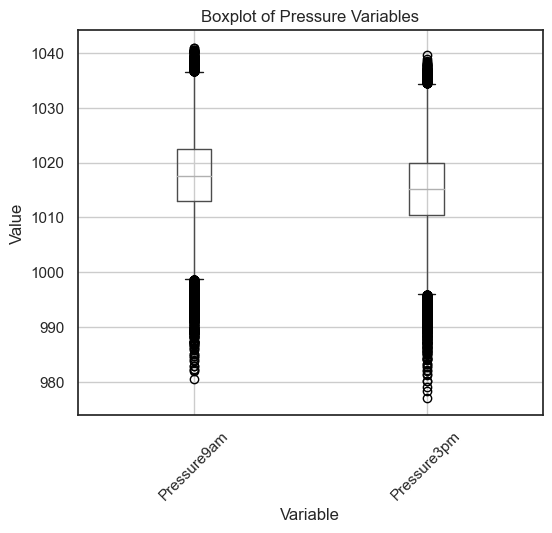

In [161]:
df = pd.DataFrame(data, columns=['Pressure9am', 'Pressure3pm'])

# Plot boxplots for each column
plt.figure(figsize=(6,5))
df.boxplot(grid=True)
plt.title('Boxplot of Pressure Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation=45)  


(array([1, 2]), [Text(1, 0, 'Cloud9am'), Text(2, 0, 'Cloud3pm')])

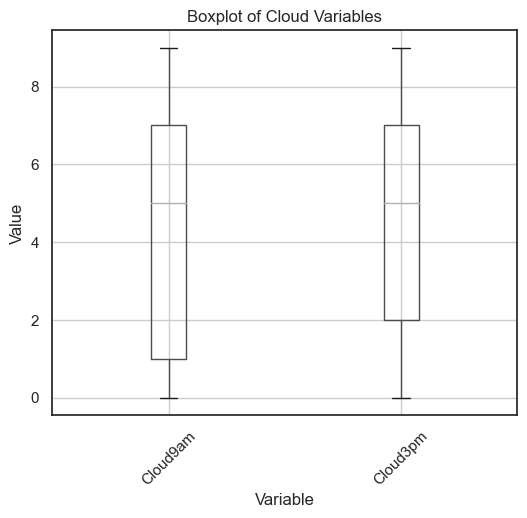

In [162]:
df = pd.DataFrame(data, columns=['Cloud9am', 'Cloud3pm'])

# Plot boxplots for each column
plt.figure(figsize=(6,5))
df.boxplot(grid=True)
plt.title('Boxplot of Cloud Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation=45)  


We can notice that most of the features contain outliers except for ['Cloud9am','Cloud3pm', 'Humidity3pm'].
 
 ==> The features with outliers will be handled using median imputation
 
 ==> The features with no outliers will be handled using mean imputation

In [164]:
print('The numerical variables with missing values are:')
columns_with_missing_float = missing_data_table.loc[(missing_data_table['missing_values'] > 0) & 
                                                    (missing_data_table['data type'] == 'float64'), 'missing_values'].index.tolist()

print(columns_with_missing_float)


['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am', 'Pressure9am', 'Pressure3pm', 'WindGustSpeed', 'Humidity3pm', 'Temp3pm', 'Rainfall', 'WindSpeed3pm', 'Humidity9am', 'WindSpeed9am', 'Temp9am', 'MinTemp', 'MaxTemp']


In [168]:
columns_without_outliers = ['Cloud9am','Cloud3pm', 'Humidity3pm']
for column in columns_with_missing_float:
    if column in columns_without_outliers : 
        data[column] =  data[column].fillna(data[column].mean())
    else:
        data[column] =  data[column].fillna(data[column].median())
        

In [172]:
print('Now we have no missing values in our numerical variables :) :)')
data[columns_with_missing_float].isna().sum()

Now we have no missing values in our numerical variables :) :)


Sunshine         0
Evaporation      0
Cloud3pm         0
Cloud9am         0
Pressure9am      0
Pressure3pm      0
WindGustSpeed    0
Humidity3pm      0
Temp3pm          0
Rainfall         0
WindSpeed3pm     0
Humidity9am      0
WindSpeed9am     0
Temp9am          0
MinTemp          0
MaxTemp          0
dtype: int64

Now, Let's handle the null values in the categorical variables!

In [175]:
print('The categorical variables with missing values are:')
columns_with_missing_categorical = missing_data_table.loc[(missing_data_table['missing_values'] > 0) & 
                                                    (missing_data_table['data type'] == 'object'), 'missing_values'].index.tolist()

print(columns_with_missing_categorical)

The categorical variables with missing values are:
['WindDir9am', 'WindGustDir', 'WindDir3pm', 'RainToday']


We will impute the categorical columns with mode.

In [178]:
for column in columns_with_missing_categorical:
    data[column] =  data[column].fillna(data[column].mode()[0])

In [182]:
if data.any().isna().sum() == 0: 
    print('NO MISSING VALUES IN OUR DATASET!!!')

NO MISSING VALUES IN OUR DATASET!!! :) :)


### SECONDLY: Let's Handle Outliers

In [183]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

MinTemp           9.1
MaxTemp          10.2
Rainfall          0.6
Evaporation       1.2
Sunshine          0.5
WindGustSpeed    15.0
WindSpeed9am     12.0
WindSpeed3pm     11.0
Humidity9am      26.0
Humidity3pm      28.0
Pressure9am       8.3
Pressure3pm       8.3
Cloud9am          3.0
Cloud3pm          2.0
Temp9am           9.2
Temp3pm           9.5
dtype: float64


In [187]:
# Removing outliers from the dataset
data = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
data.shape

(53800, 23)

We still have some pre processing to do, but at this stade we're just going to keep a copy of our actual data to use it for visualizations

In [189]:
data_viz = data.copy()

### THIRD: Let's Encode categorical variables

Before that let's transform our target variable to a numerical variable. **Yes --> 1 and No --> 0**. And we'll do it for both **'RainToday' and 'RainTomorrow'** variables to keep our data consistent.

In [190]:
data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

Now let's transform our Date column by splitting it to Year, month and day columns and converting them to numerical values

In [200]:
data[['year', 'month', 'day']] = data['Date'].str.split('-', expand=True)
data = data.drop(['Date'], axis=1)

In [201]:
data[['year', 'month', 'day']] = data[['year', 'month', 'day']].astype(int)


Let's take a look on our 3 last categorical variables ['WindGustDir','WindDir9am','WindDir3pm']. Since they all concern the Wind caracteristic, we assume that they have the same unique values. Let's see whether our assumption is correct. 

In [213]:
set(data['WindGustDir'].unique())==set(data['WindDir3pm'].unique()) == set(data['WindDir3pm'].unique())

True

This means that we have to encode them with the same encoder

In [219]:
label_encoder = LabelEncoder()

unique_values = list(set(data['WindGustDir'].unique()))
label_encoder.fit(unique_values)

# Encode values of all three columns
data['WindGustDir'] = label_encoder.transform(data['WindGustDir'])
data['WindDir9am'] = label_encoder.transform(data['WindDir9am'])
data['WindDir3pm'] = label_encoder.transform(data['WindDir3pm'])


Proceeding the same way, we will encode the 'Location' variable

In [230]:
data['Location'] = label_encoder.fit_transform(data['Location'])


### LASTLY: Let's split our data

In [231]:
X = data.drop(columns=['RainTomorrow'])  # Our Features
y = data['RainTomorrow']  # Our Target

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The shapes of the resulting datasets
print("Training set shape :", (X_train.shape[0], X_train.shape[1]+1))
print("Test set shape :", (X_test.shape[0], X_test.shape[1]+1))


Training set shape : (43040, 28)
Test set shape : (10760, 28)


### Let's balance our data using SMOTE

In [243]:
smote = SMOTE()
# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X_train, y_train)


In [244]:
def Counter(y):
    Counter = {}
    Counter[0] = y.value_counts()[0]
    Counter[1] = y.value_counts()[1]
    return Counter

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape {0: 36555, 1: 6485}
Resample dataset shape {0: 36555, 1: 36555}


In [246]:
train_data = pd.concat([X_smote, y_smote], axis=1)
print("Shape of our balanced train data:", train_data.shape)

Shape of our balanced train data: (73110, 28)


# Bivariate Analysis between continuous variables

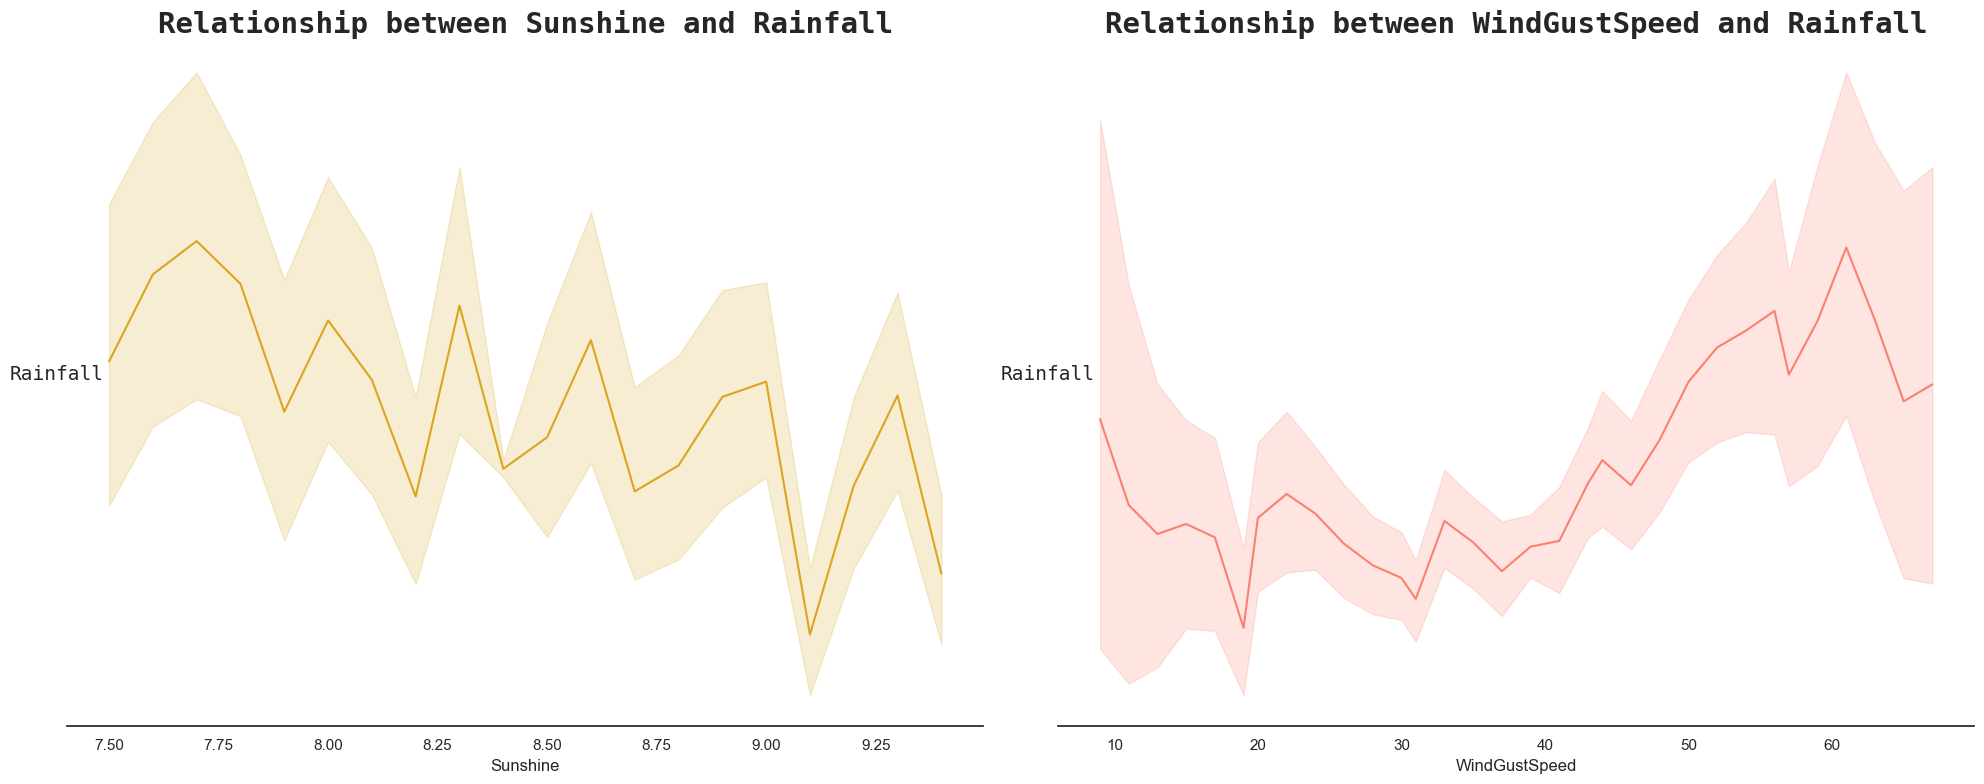

In [239]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), facecolor='white')

titles = ["Relationship between Sunshine and Rainfall", "Relationship between WindGustSpeed and Rainfall"]
x_labels = ['Sunshine', 'WindGustSpeed']

for ax, title, x_label in zip(axes, titles, x_labels):
    ax.set_title(title, fontsize=21, fontweight='bold', fontfamily='monospace')
    sns.lineplot(data=data_viz, x=x_label, y='Rainfall', ax=ax, color='goldenrod' if x_label == 'Sunshine' else 'salmon')
    ax.set_ylabel('Rainfall', rotation=0, fontsize=14, fontfamily='monospace')
    ax.set_yticklabels('')
    ax.tick_params(axis='y', length=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


**We can see that tha rainfall decreases when there's sunshine during the day. While we can see that there's no observable relationship between the wind speed and the rainfall. We can confirm this laast observation by plotting the relationship between WindSpeed at 9 am and 3 pm and the Rainfall.**

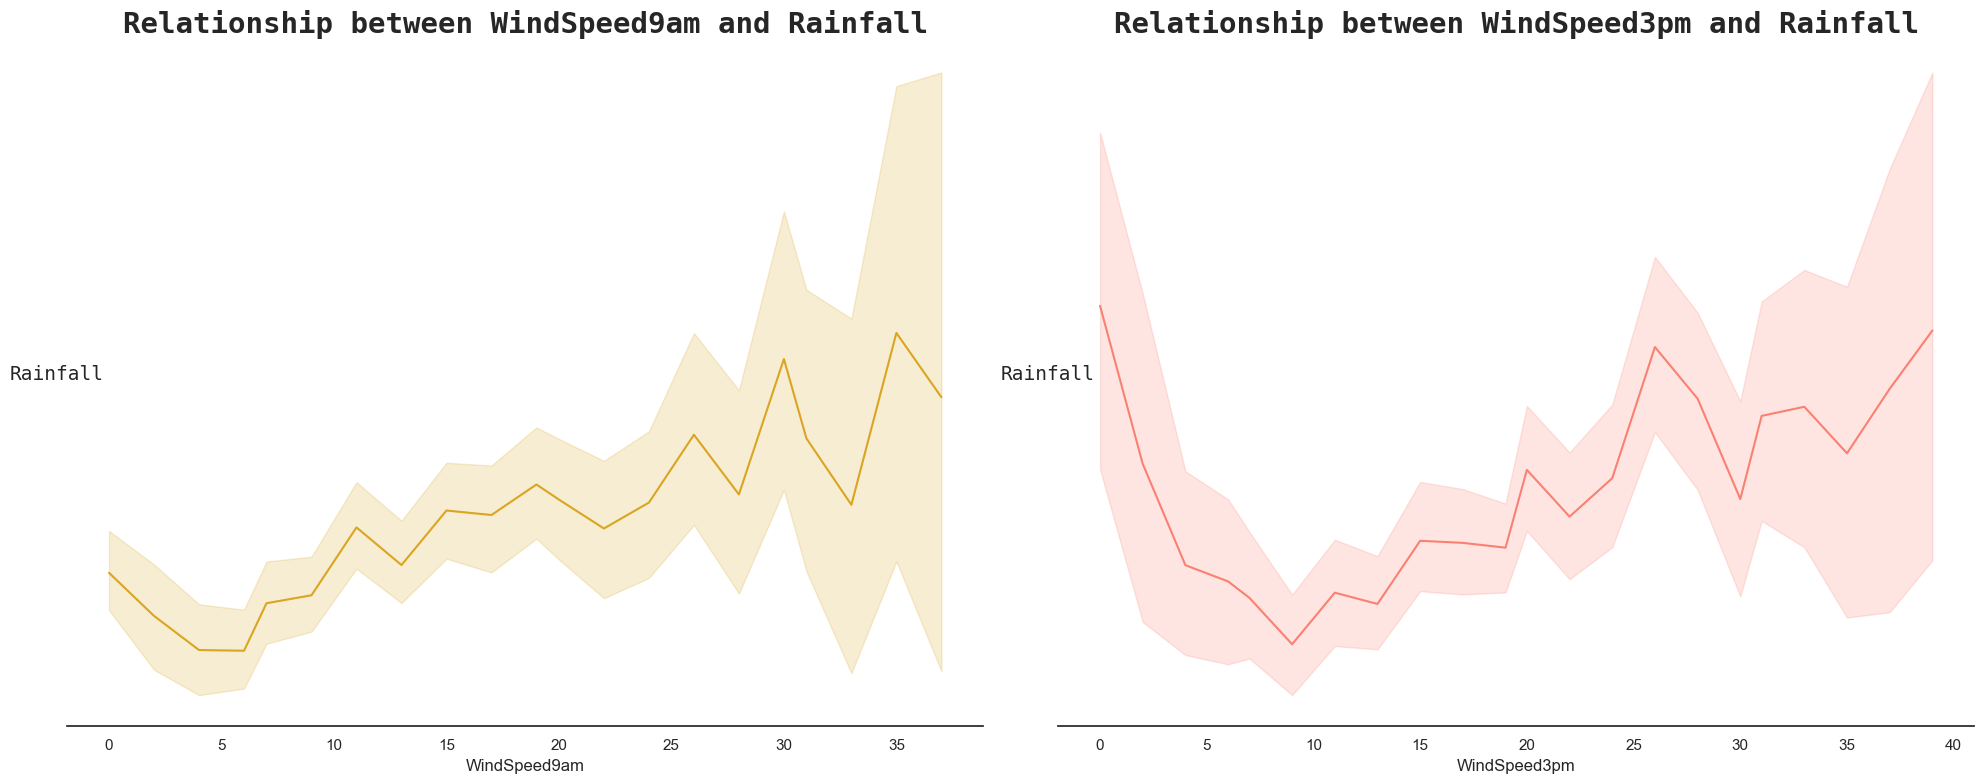

In [240]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), facecolor='white')

titles = ["Relationship between WindSpeed9am and Rainfall", "Relationship between WindSpeed3pm and Rainfall"]
x_labels = ['WindSpeed9am', 'WindSpeed3pm']

for ax, title, x_label in zip(axes, titles, x_labels):
    ax.set_title(title, fontsize=21, fontweight='bold', fontfamily='monospace')
    sns.lineplot(data=data_viz, x=x_label, y='Rainfall', ax=ax, color='goldenrod' if x_label == 'WindSpeed9am' else 'salmon')
    ax.set_ylabel('Rainfall', rotation=0, fontsize=14, fontfamily='monospace')
    ax.set_yticklabels('')
    ax.tick_params(axis='y', length=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()



In [241]:
fig = px.scatter(data_viz, x="WindSpeed9am", y="WindSpeed3pm", color="Rainfall", title="Relationship between WindSpeed9am, WindSpeed3pm, and Rainfall")
fig.update_layout(width=800, height=600)
fig.show()

**We can comfirm by the two above figure that there's no remarkable relationship between the wind speed and the rainfall**

In [242]:
fig = px.scatter(data_viz, x="MinTemp", y="MaxTemp", color="Rainfall", title="Relationship between MinTemp, MaxTemp, and Rainfall")
fig.update_layout(width=800, height=600)
fig.show()

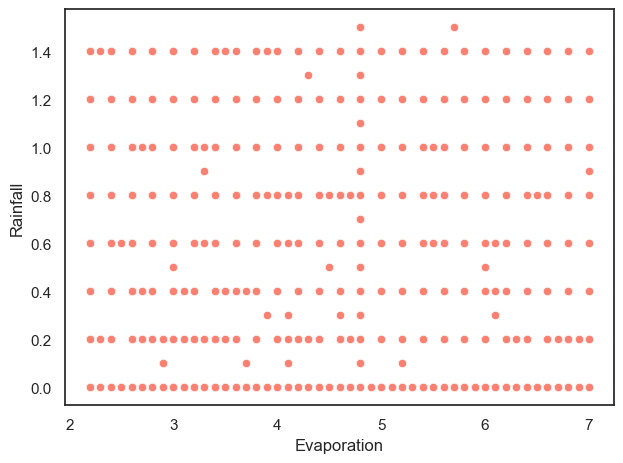

In [247]:
sns.scatterplot(data=data_viz,x='Evaporation',y='Rainfall',color='salmon')
plt.tight_layout()
plt.show()

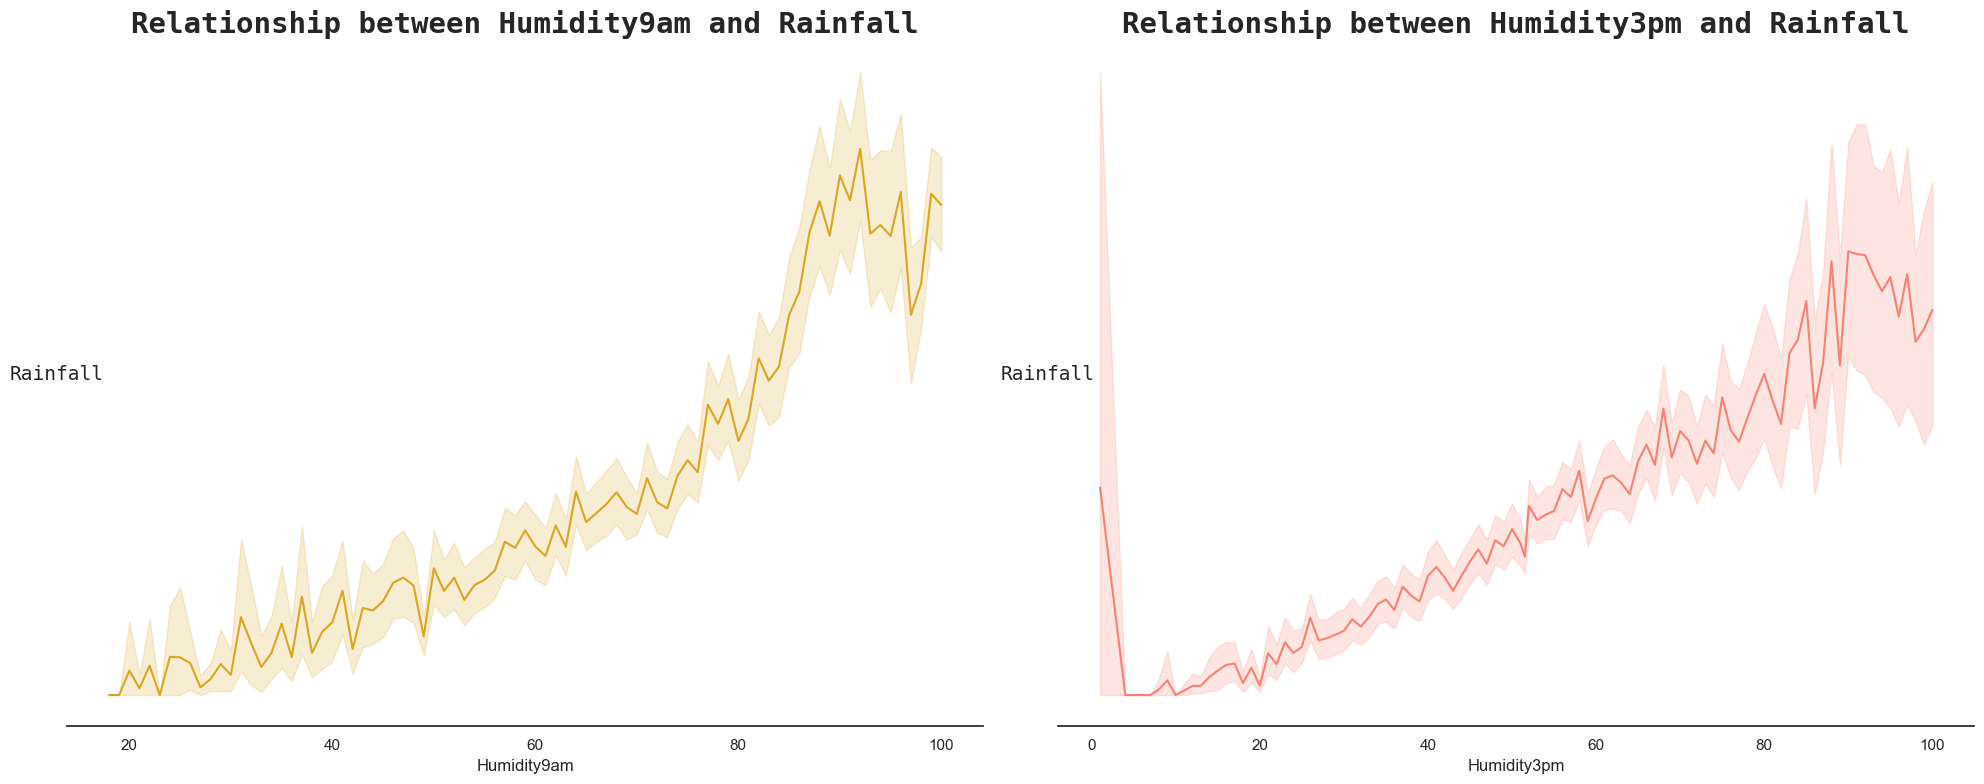

In [248]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), facecolor='white')

titles = ["Relationship between Humidity9am and Rainfall", "Relationship between Humidity3pm and Rainfall"]
x_labels = ['Humidity9am', 'Humidity3pm']

for ax, title, x_label in zip(axes, titles, x_labels):
    ax.set_title(title, fontsize=21, fontweight='bold', fontfamily='monospace')
    sns.lineplot(data=data_viz, x=x_label, y='Rainfall', ax=ax, color='goldenrod' if x_label == 'Humidity9am' else 'salmon')
    ax.set_ylabel('Rainfall', rotation=0, fontsize=14, fontfamily='monospace')
    ax.set_yticklabels('')
    ax.tick_params(axis='y', length=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


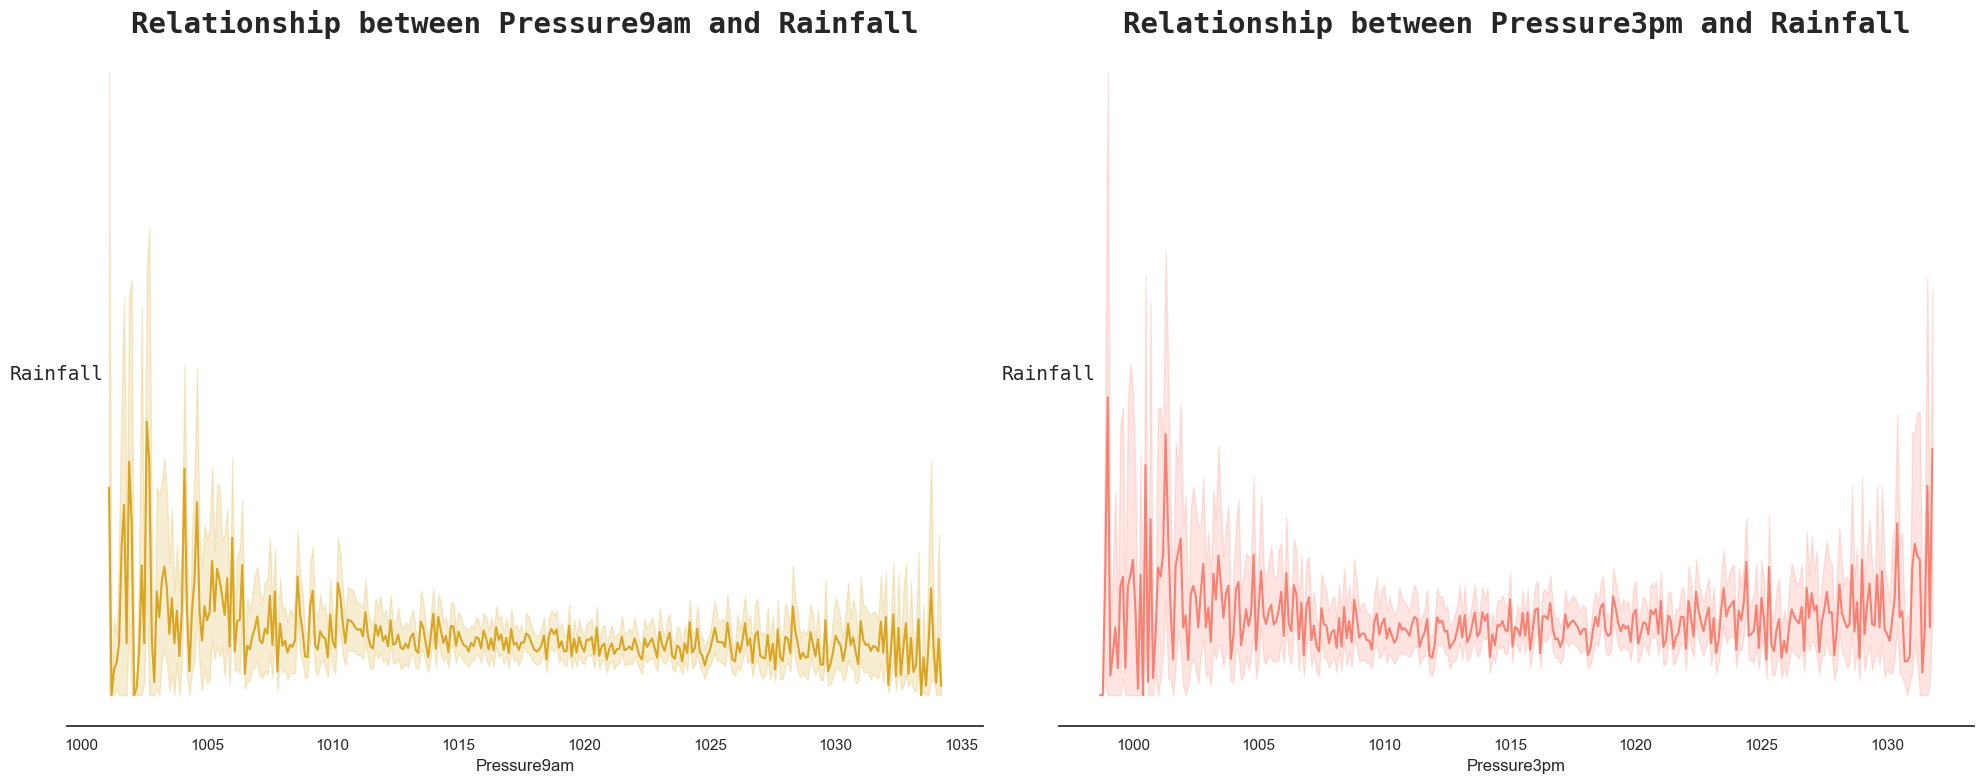

In [249]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), facecolor='white')

titles = ["Relationship between Pressure9am and Rainfall", "Relationship between Pressure3pm and Rainfall"]
x_labels = ['Pressure9am', 'Pressure3pm']

for ax, title, x_label in zip(axes, titles, x_labels):
    ax.set_title(title, fontsize=21, fontweight='bold', fontfamily='monospace')
    sns.lineplot(data=data_viz, x=x_label, y='Rainfall', ax=ax, color='goldenrod' if x_label == 'Pressure9am' else 'salmon')
    ax.set_ylabel('Rainfall', rotation=0, fontsize=14, fontfamily='monospace')
    ax.set_yticklabels('')
    ax.tick_params(axis='y', length=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


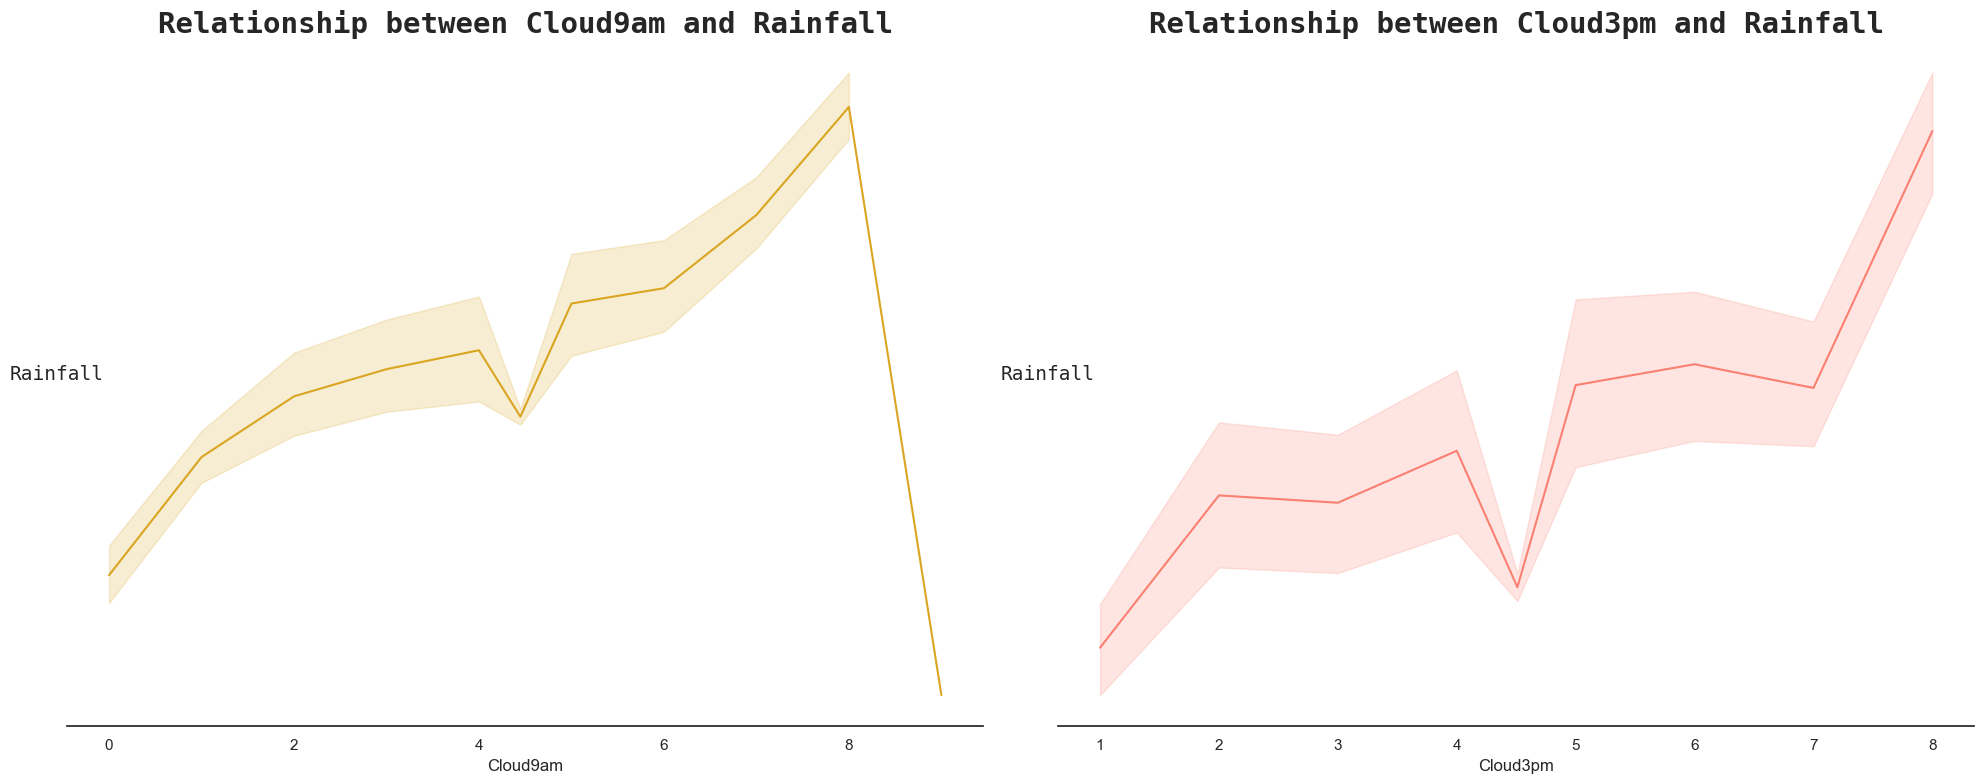

In [250]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8), facecolor='white')

titles = ["Relationship between Cloud9am and Rainfall", "Relationship between Cloud3pm and Rainfall"]
x_labels = ['Cloud9am', 'Cloud3pm']

for ax, title, x_label in zip(axes, titles, x_labels):
    ax.set_title(title, fontsize=21, fontweight='bold', fontfamily='monospace')
    sns.lineplot(data=data_viz, x=x_label, y='Rainfall', ax=ax, color='goldenrod' if x_label == 'Cloud9am' else 'salmon')
    ax.set_ylabel('Rainfall', rotation=0, fontsize=14, fontfamily='monospace')
    ax.set_yticklabels('')
    ax.tick_params(axis='y', length=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


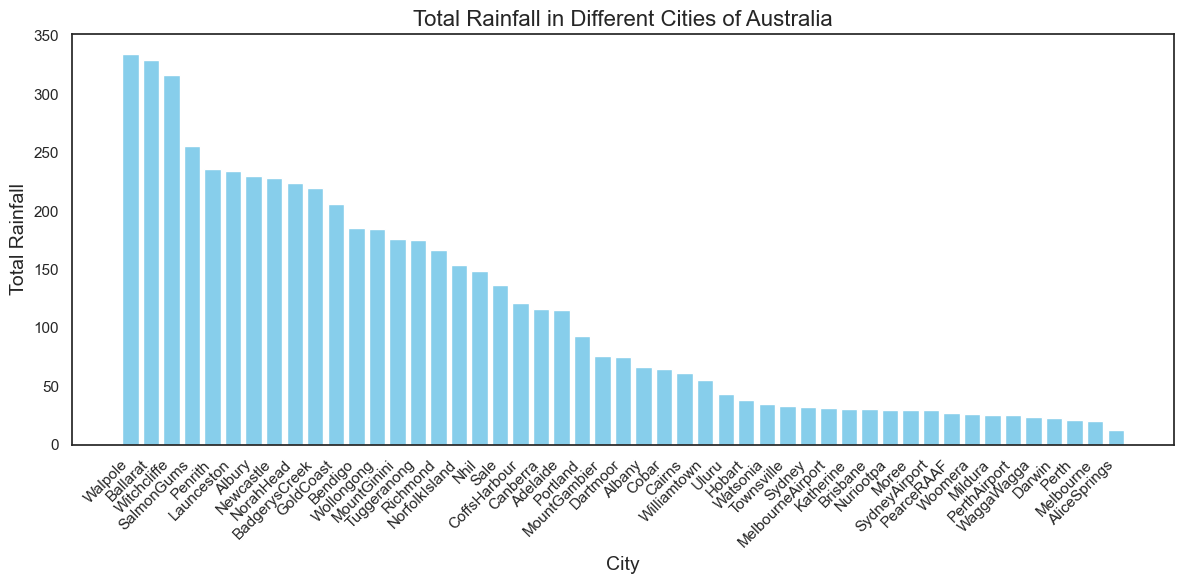

In [251]:
city_rainfall_totals = data_viz.groupby('Location')['Rainfall'].sum().reset_index()

city_rainfall_totals = city_rainfall_totals.sort_values(by='Rainfall', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(city_rainfall_totals['Location'], city_rainfall_totals['Rainfall'], color='skyblue')

# Add labels and title
plt.xlabel('City', fontsize=14)
plt.ylabel('Total Rainfall', fontsize=14)
plt.title('Total Rainfall in Different Cities of Australia', fontsize=16)
plt.xticks(rotation=45, ha='right')  
# Show the plot
plt.tight_layout()
plt.show()

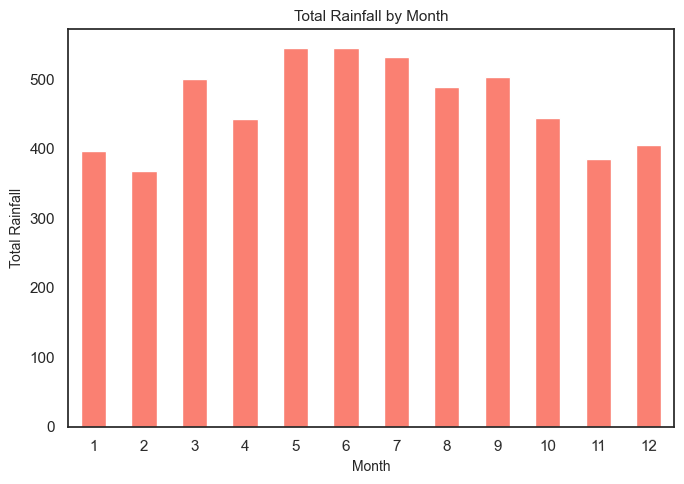

In [260]:
df = data_viz.copy()
df['Date'] = pd.to_datetime(df['Date'])  
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

unique_months = df['month'].nunique()

monthly_rainfall = df.groupby('month')['Rainfall'].sum()

plt.figure(figsize=(7, 5))
monthly_rainfall.plot(kind='bar', color='salmon')

plt.xlabel('Month', fontsize=10)
plt.ylabel('Total Rainfall', fontsize=10)
plt.title('Total Rainfall by Month', fontsize=11)
plt.xticks(rotation=1) 

plt.tight_layout()
plt.show()

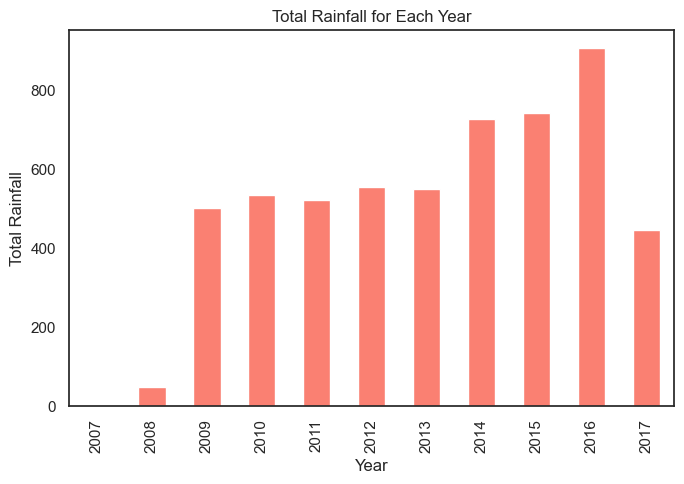

In [264]:
total_rainfall_per_year = data.groupby('year')['Rainfall'].sum()

plt.figure(figsize=(7, 5))
total_rainfall_per_year.plot(kind='bar', color='salmon')
plt.title('Total Rainfall for Each Year')
plt.xlabel('Year')
plt.ylabel('Total Rainfall')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Feature selection 

C:\Users\BOUFARIS JINANE\AppData\Local\Temp\ipykernel_20464\2584035431.py:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



<AxesSubplot:>

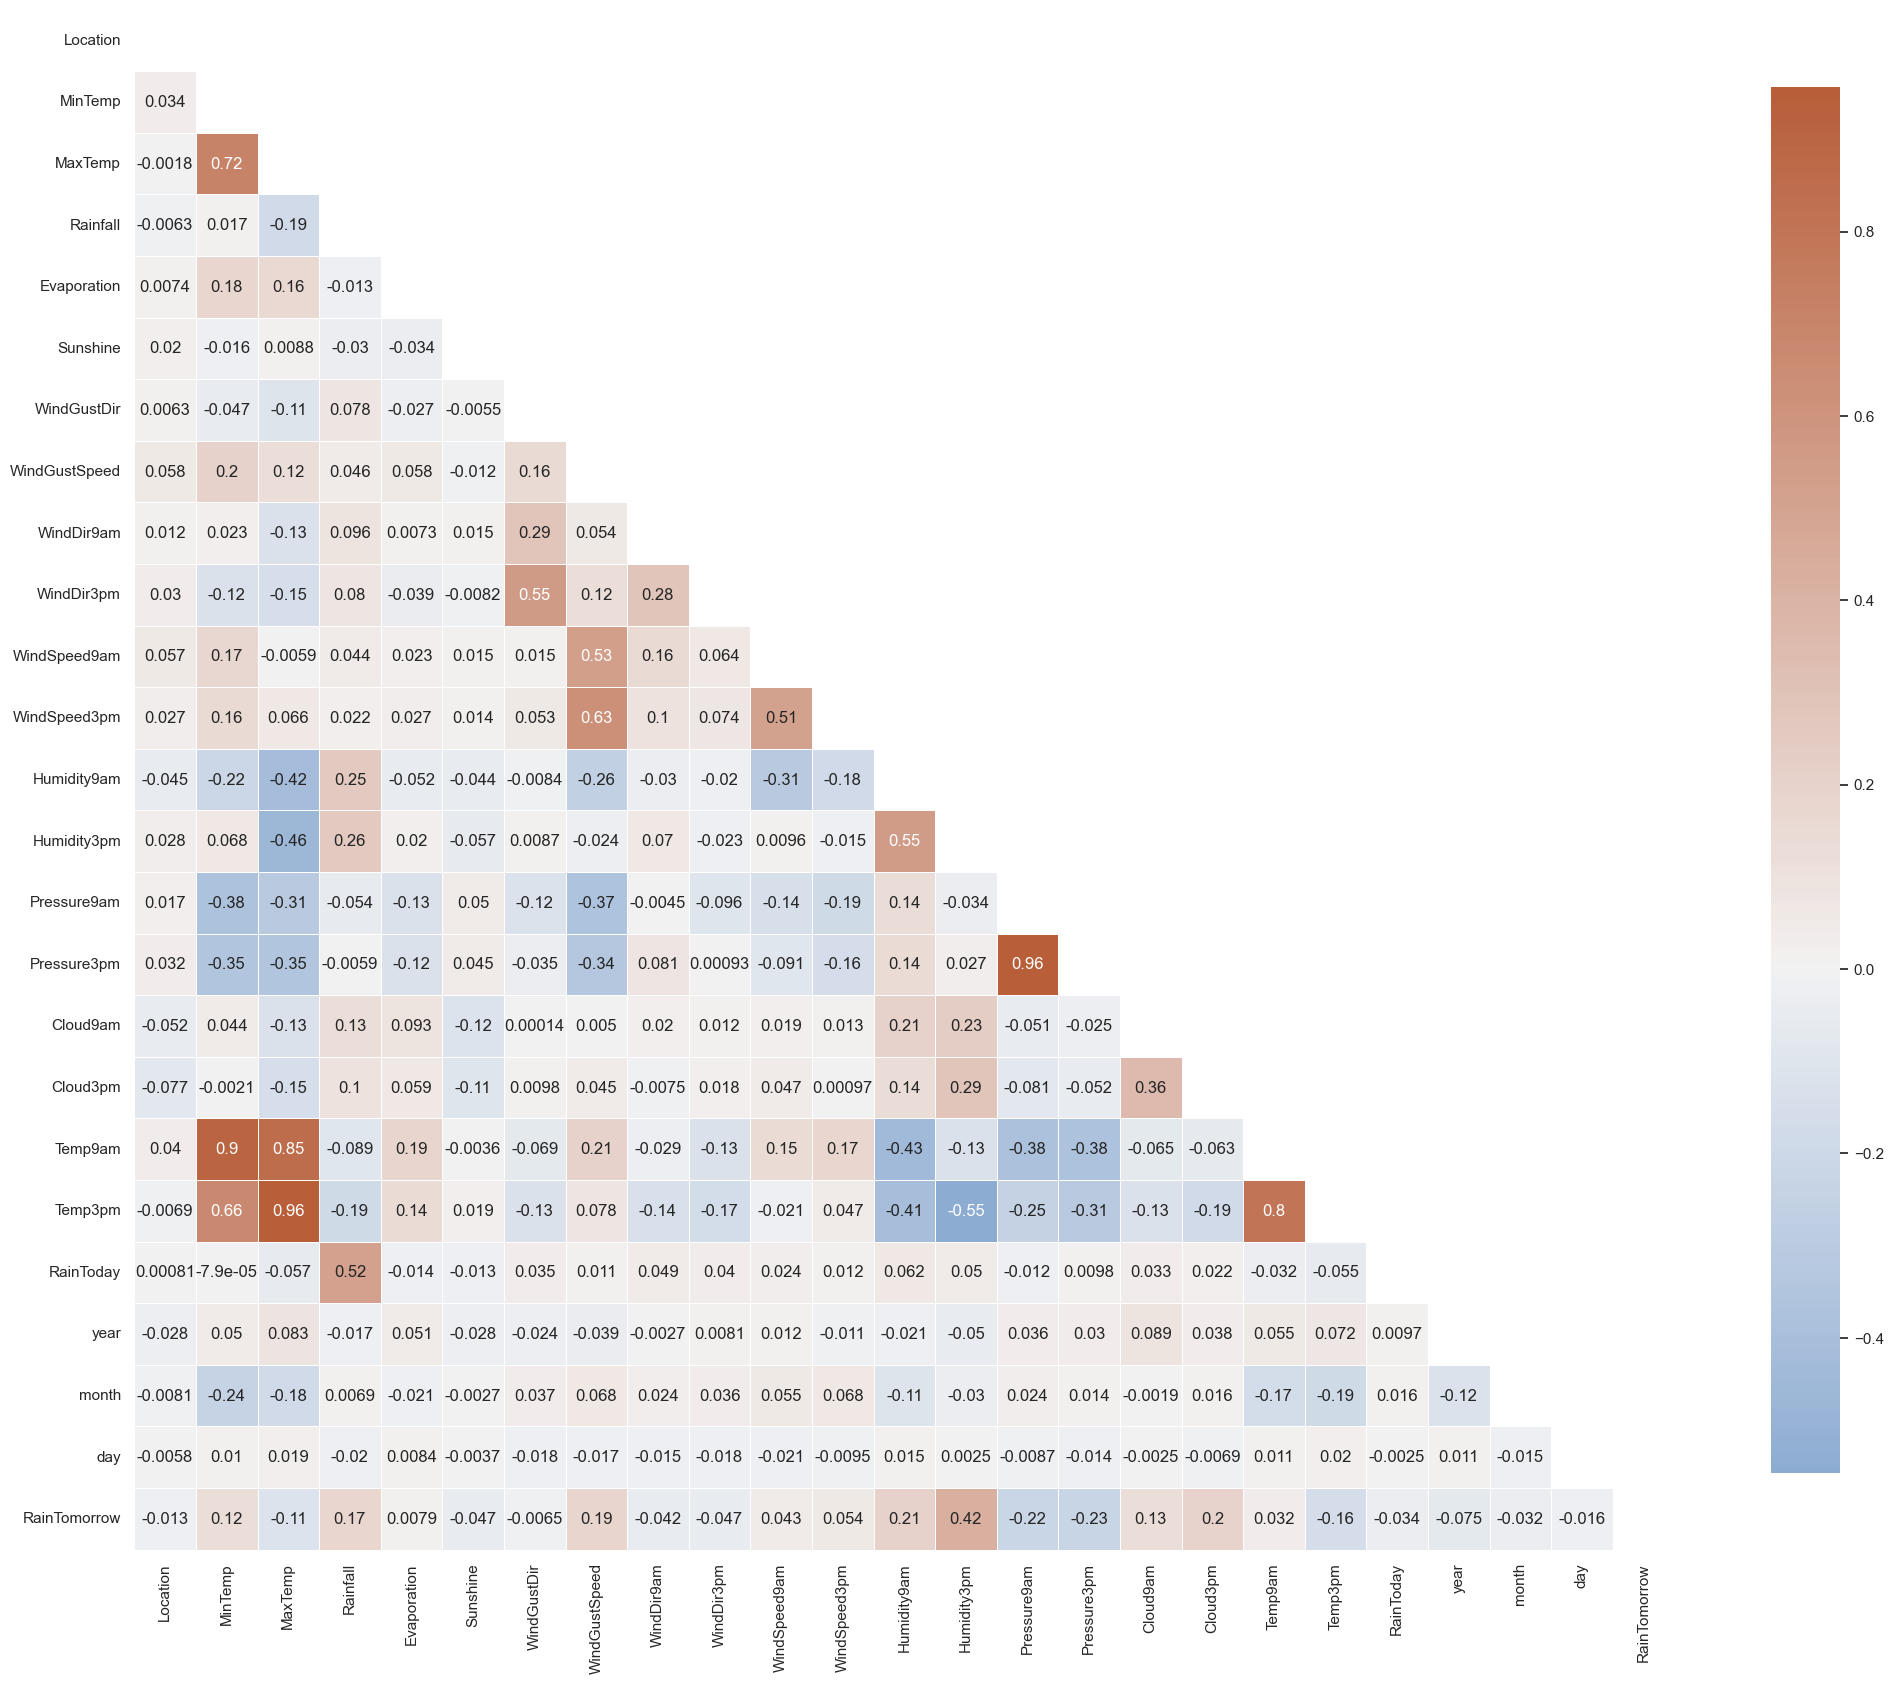

In [271]:
corr = train_data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(25, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})